# Modified the plot images

In [2]:
from __future__ import print_function, division


from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf

import matplotlib.pyplot as plt

import sys

import numpy as np

import os


Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_54 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_189 (Dense)            (None, 512)               6291968   
_________________________________________________________________
leaky_re_lu_135 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_190 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_136 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 257       
Total params: 6,423,553
Trainable params: 6,423,553
Non-trainable params: 0
___________________________________________

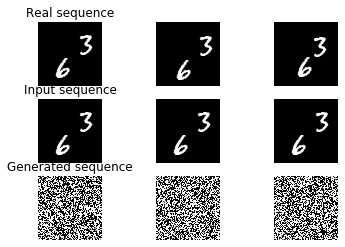

In [30]:
class GAN():
    def __init__(self):
        self.img_rows = 64 #28
        self.img_cols = 64 #28
        self.channels = 3 #1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Cut and load the dataset to shape (60000,64,64,3)
        data = np.load("mnist_test_seq.npy")
        self.Y_train = np.concatenate((data[0:3],data[3:6],data[6:9],data[9:12],data[12:15],data[15:18]),axis=1).transpose(1,2,3,0)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes sta_imgs as input and generates gen_imgs
        sta_imgs = Input(shape=(self.img_shape))
        gen_imgs = self.generator(sta_imgs)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(gen_imgs)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(sta_imgs, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        

        # Set checkpoints and save trained models
        self.checkpoint_dir = 'training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer,
                                         discriminator_optimizer=optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)


    def build_generator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        sta_imgs = Input(shape=(self.img_shape))
        gen_imgs = model(sta_imgs)

        return Model(sta_imgs, gen_imgs)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        
        model.summary()

        sam_imgs = Input(shape=self.img_shape)
        validity = model(sam_imgs)

        return Model(sam_imgs, validity)

    def train(self, epochs, batch_size=32 , sample_interval=30):


        # Rescale -1 to 1
        Y_train = self.Y_train / 127.5 - 1.
        

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))


        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, Y_train.shape[0], batch_size) 
            sam_imgs = Y_train[idx] #For Y_train
            
            X_train = np.expand_dims(Y_train[:,:,:,0], axis=3) #For X_train
            X_train = np.concatenate((X_train,X_train,X_train),axis=3)
            sta_imgs = X_train[idx]
            
            # Generate a batch of new images
            gen_imgs = self.generator.predict(sta_imgs)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(sam_imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(sta_imgs, valid)

            # Plot the progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # Save the models every 10 epochs
            if (epoch + 1) % 50 == 0:
                self.checkpoint.save(file_prefix = self.checkpoint_prefix)
                
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)


    def sample_images(self, epoch):

        # Select Y_train and X_train
        Y_train = self.Y_train
        X_train = np.expand_dims(Y_train[:,:,:,0], axis=3) 
        X_train = np.concatenate((X_train,X_train,X_train),axis=3)
        
        # Select a clip for ploting
        idx = np.random.randint(0, Y_train.shape[0], 32)
        sta_imgs = X_train[idx][0]
        gen_imgs = self.generator.predict(X_train[idx])[0]
        sam_imgs = Y_train[idx][0]

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        sam_imgs = 0.5 * sam_imgs + 0.5
        sta_imgs = 0.5 * sta_imgs + 0.5
        
        # Plot images
        fig = plt.figure()
        row1 = plt.subplot(3,3,1)
        plt.imshow(sam_imgs[:,:,0], cmap='gray')
        row1.title.set_text("Real sequence")
        plt.axis("off")
        plt.subplot(3,3,2)
        plt.imshow(sam_imgs[:,:,1], cmap='gray')
        plt.axis("off")
        plt.subplot(3,3,3)
        plt.imshow(sam_imgs[:,:,2], cmap='gray')
        plt.axis("off")

        row2 = plt.subplot(3,3,4)
        plt.imshow(sta_imgs[:,:,0], cmap='gray')
        row2.title.set_text("Input sequence")
        plt.axis("off")
        plt.subplot(3,3,5)
        plt.imshow(sta_imgs[:,:,1], cmap='gray')
        plt.axis("off")
        plt.subplot(3,3,6)
        plt.imshow(sta_imgs[:,:,2], cmap='gray')
        plt.axis("off")
                
        row2 = plt.subplot(3,3,7)
        plt.imshow(gen_imgs[:,:,0], cmap='gray')
        row2.title.set_text("Generated sequence")
        plt.axis("off")
        plt.subplot(3,3,8)
        plt.imshow(gen_imgs[:,:,1], cmap='gray')
        plt.axis("off")
        plt.subplot(3,3,9)
        plt.imshow(gen_imgs[:,:,2], cmap='gray')
        plt.axis("off")

        
#         epoch = str(int(epoch))
        fig.savefig("generated_images/%s.png" % epoch) #%d
        plt.close()



if __name__ == '__main__':
    gan = GAN()
    gan.checkpoint.restore(tf.train.latest_checkpoint(gan.checkpoint_dir))
#     gan.sample_images("test")
    gan.train(epochs=50, batch_size=32, sample_interval=20)